# Transfer learning with Tensorflow
在这个Notebook当中，我们将介绍如何实用Tensorflow框架实现迁移学习。简单的来说，迁移学习就是利用已经训练好的模型中学习到的特征（Features），再根据用户需要添加额外的网络层，进行快速的针对新的特定的数据集的模型训练。由于这样生成的模型大部分的模型参数已经训练好并且已经学习到一定数量的hidden features，在提供新的数据集的时候再进行训练就能有效利用已学习到的知识来进行预测。

本notebook所使用的预训练好的模型是MobileNet V2，其具体的原理就留给负责这部分的同学在后续具体介绍。我们当前只需要了解其大致的网络结构即可（结构如下图）。

![MobileNet-v2-1](./imgs/mobilenet_v2_1.png)

![MobileNet-v2-2](./imgs/mobilenet_v2_2.png)

MobileNet论文：https://arxiv.org/abs/1801.04381

我们使用的是“猫猫狗狗”数据集，具体的样例我们会在下文的数据部分展示。

下面是大纲：

1. 数据集 & 构造模型输入流
2. 组合模型
    - 载入预训练好的模型及其参数
    - 在预训练好的模型的基础上添加额外的分类层
3. 训练模型
4. 测试模型

参考文献：https://tensorflow.google.cn/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## 1. 数据预处理
### 数据集分组
在这里我们数据集已经按照路径分为Train集和Validation集。

In [2]:
PATH = os.path.join('./data', 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### 查看数据集中的样本

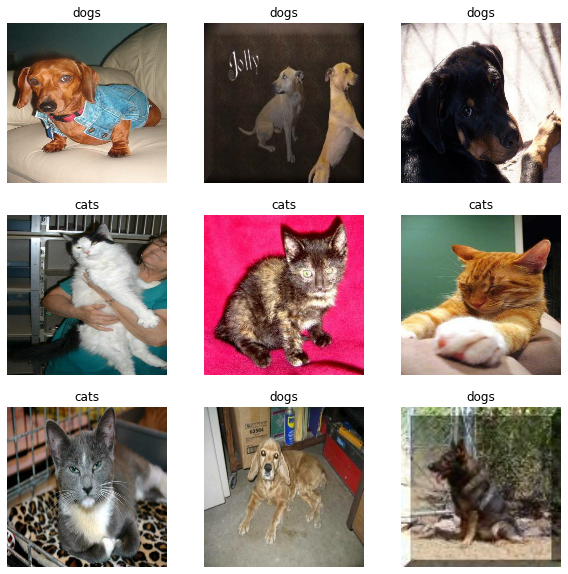

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### 将图片像素值归一化

In [4]:
rescale_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0)

## 2.组合模型
### 载入预训练好的模型（MobileNet-v2）

In [5]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [6]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### 特征提取（Feature Extraction）

In [7]:
# Freeze the MobileNet
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### 将上述的各个层集合成新的 Model

In [14]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = rescale_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### 编译模型

In [17]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics='accuracy')

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 1280)        0         
_________________________________________________________________
dense_3 (Dense)              (None, 5, 5, 1)           1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## 3.训练模型

### 迁移学习后的Validation准确率

In [15]:
epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 33s 501ms/step - loss: 0.6727 - accuracy: 0.5925 - val_loss: 0.5018 - val_accuracy: 0.7060
Epoch 2/10
63/63 [==============================] - 23s 360ms/step - loss: 0.4419 - accuracy: 0.7635 - val_loss: 0.3507 - val_accuracy: 0.8390
Epoch 3/10
63/63 [==============================] - 19s 294ms/step - loss: 0.3292 - accuracy: 0.8435 - val_loss: 0.2682 - val_accuracy: 0.9110
Epoch 4/10
63/63 [==============================] - 19s 295ms/step - loss: 0.2573 - accuracy: 0.9000 - val_loss: 0.2208 - val_accuracy: 0.9310
Epoch 5/10
63/63 [==============================] - 19s 296ms/step - loss: 0.2187 - accuracy: 0.9180 - val_loss: 0.1895 - val_accuracy: 0.9430
Epoch 6/10
63/63 [==============================] - 20s 315ms/step - loss: 0.1942 - accuracy: 0.9280 - val_loss: 0.1679 - val_accuracy: 0.9510
Epoch 7/10
63/63 [==============================] - 19s 307ms/step - loss: 0.1683 - accuracy: 0.9360 - val_loss: 0.1523 - val_accuracy: 0.9540

### 学习曲线

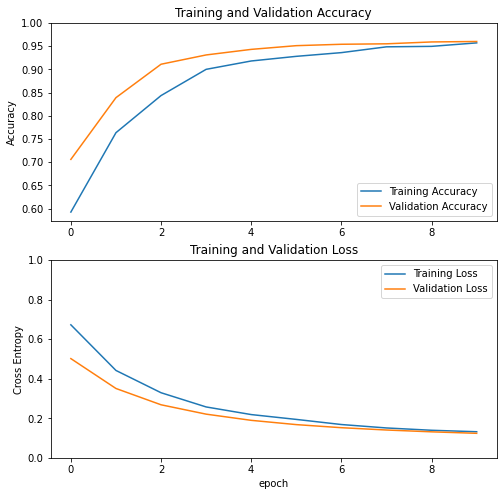

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()